In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import math
# from scipy import stats
# import warnings
# import re
# import datetime
# from package.utils import DotDict, timer, get_config, load_data, merge_data
# import yaml
# from itertools import product
# from tqdm import tqdm
# import re
# import matplotlib.colors as mcolors
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, fbeta_score
# warnings.filterwarnings("ignore", category=UserWarning)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', 300)

In [3]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import silhouette_score
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import NearestNeighbors
# from sklearn.metrics.pairwise import euclidean_distances
# import joblib
# import boto3
# import io
# import gc

In [4]:
# from package.check import *
# from package.fai import plot_dual_axis_plotly
# from package.fraud_ml import *
# from package.clustering import get_model

## Autoencoder

In [5]:
!pip install tensorflow

^C


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Generate mock data
def generate_mock_data(n_sales=300, n_rules=10, fraud_ratio=0.05, seed=42):
    np.random.seed(seed)
    
    timeunits = ['l3', 'l6', 'l9' , 'l12', 'l24','l36']
    sales_ids = np.arange(n_sales)
    all_data = []

    # Assign fraud at sales_id level (consistent across timeunits)
    is_fraud = np.random.choice([0, 1], size=n_sales, p=[1-fraud_ratio, fraud_ratio])
    sales_id_fraud_map = dict(zip(sales_ids, is_fraud))
    
    for t in timeunits:
        for s_id in sales_ids:
            row = {
                'sales_id': s_id,
                'timeunit': t,
                'flag_fraud': sales_id_fraud_map[s_id]
            }
            for i in range(1, n_rules + 1):
                base_val = np.random.normal(loc=0, scale=1)
                if sales_id_fraud_map[s_id] == 1:
                    base_val += np.random.normal(loc=3, scale=1.5)
                row[f'rule_{i}'] = base_val
            all_data.append(row)
    
    df = pd.DataFrame(all_data)
    return df

In [21]:
mock1 = generate_mock_data(n_sales=10000, n_rules=10, fraud_ratio=0.05, seed=42)
mock1

,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
0,0,l3,0,-1.487862,-1.125186,0.388819,-1.173873,1.112634,-0.071120,0.085595,-0.278373,0.772848,0.783160
1,1,l3,1,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755,1.086816
2,2,l3,0,0.608267,1.345935,-0.174648,1.360168,-0.189693,0.849585,-2.218570,2.418778,1.495458,-0.284626
3,3,l3,0,-1.972089,0.288028,-1.443926,0.444854,0.411566,-0.941403,1.120967,0.805575,0.975823,0.008858
4,4,l3,0,-1.415524,0.977872,-0.270371,-1.389780,1.352039,2.099408,-0.041248,2.159121,0.091315,-0.380456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9995,l36,0,0.647493,-0.163831,-1.743780,1.184970,-0.193500,-1.273190,0.773532,-1.803990,2.209333,-0.800634
59996,9996,l36,0,-0.716390,1.700367,-0.933375,0.191027,-1.348096,2.584121,-0.054343,-1.355835,1.124099,0.609250
59997,9997,l36,0,1.066770,-1.592284,-1.706892,1.178747,0.985029,0.364593,-2.039914,-0.325981,0.478952,0.808948
59998,9998,l36,0,1.622065,-0.303766,1.377932,-0.777375,-0.179569,0.607243,-1.106324,-0.591367,0.501293,0.450664


In [22]:
mock1[mock1['sales_id']==500]

,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
500,500,l3,0,0.166968,1.460680,-0.610763,0.106670,0.747059,-1.321209,3.096589,0.028566,0.141989,1.256878
10500,500,l6,0,-0.073630,0.301153,0.616660,-1.569894,-0.348854,-0.788112,-1.733676,-0.985178,1.020987,-0.254389
20500,500,l9,0,-1.102702,1.092087,0.867330,0.959610,-0.033662,-1.215877,-0.417598,0.135218,-0.373176,1.078219
30500,500,l12,0,-0.820564,0.947833,0.971056,-0.700119,0.724817,0.769781,-1.355791,2.047062,-1.484542,-0.768653
40500,500,l24,0,-0.109731,0.393684,0.790195,-0.213127,-0.359229,0.005206,-0.953972,-0.107915,-1.326031,-0.332294
50500,500,l36,0,0.062239,1.725557,0.175799,-0.605733,0.004543,-0.544945,-1.028337,0.546450,0.592578,0.994537


In [23]:
mock1[mock1['sales_id']==1]

,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
1,1,l3,1,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755,1.086816
10001,1,l6,1,1.992690,2.788892,2.641399,3.292779,3.056713,2.506039,4.922938,2.011123,3.777520,5.183808
20001,1,l9,1,3.860721,1.453199,1.186555,2.943711,1.687425,-0.344547,1.282770,3.757316,3.757815,1.615426
30001,1,l12,1,2.214356,3.323717,1.351970,4.490844,4.123939,1.937718,2.207038,0.926875,2.700979,4.692913
40001,1,l24,1,-0.011207,1.395388,7.004542,2.778126,4.224606,3.769747,2.411819,3.796941,-0.738528,4.551202
50001,1,l36,1,3.273467,3.954580,5.130358,1.143979,3.064396,1.383533,1.918352,-0.468026,0.177472,3.403392


In [34]:
# 2. Subset and prepare data
def prepare_data(df, timeunit='l3', scale=True):
    """
    Subset the data by timeunit and optionally scale it.
    
    Parameters:
    - df: DataFrame
    - timeunit: str, e.g. 'l3'
    - scale: bool, whether to apply StandardScaler
    
    Returns:
    - X_train: training data (non-fraud only)
    - X_test: full test set
    - y_test: labels for test set
    - scaler: fitted scaler or None
    """
    subset_df = df[df['timeunit'] == timeunit].reset_index(drop=True)
    features = [col for col in subset_df.columns if col.startswith('rule_')]
    X = subset_df[features].values
    y = subset_df['flag_fraud'].values

    scaler = None
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X

    X_train = X_scaled[y == 0]
    X_test = X_scaled
    y_test = y
    return X_train, X_test, y_test, scaler

In [37]:
X_train, X_test, y_test, scaler = prepare_data(mock1, timeunit='l3', scale=False)

In [38]:
len(X_train) # train only non-fraud agent

9526

In [39]:
len(X_test) # test with all agent

10000

In [40]:
len(y_test) # เฉลย for all agent

10000

In [42]:
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers


def build_autoencoder(input_dim,
                      encoding_dim=4,
                      hidden_layers=[8],
                      activation='relu',
                      loss='mse',
                      optimizer='adam'):
    """
    Build an autoencoder with customizable architecture.
    
    Parameters:
    - input_dim: int, number of input features
    - encoding_dim: int, size of latent space
    - hidden_layers: list of int, hidden layer sizes before and after latent
    - activation: str, activation function for hidden layers
    - loss: str, loss function (default: 'mse')
    - optimizer: str or optimizer object
    
    Returns:
    - autoencoder: compiled Keras model
    - encoder: encoder portion (for embedding extraction)
    """
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    x = input_layer
    for size in hidden_layers:
        x = Dense(size, activation=activation)(x)
    
    # Latent space
    latent = Dense(encoding_dim, activation=activation)(x)
    
    # Decoder (reverse hidden layers)
    x = latent
    for size in reversed(hidden_layers):
        x = Dense(size, activation=activation)(x)
    
    # Output
    output_layer = Dense(input_dim, activation='linear')(x)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    
    # Encoder model
    encoder = Model(inputs=input_layer, outputs=latent)
    
    return autoencoder, encoder

In [43]:
X_train.shape[1]

10

In [45]:
mock1_autoencoder, mock1_encoder = build_autoencoder(input_dim= X_train.shape[1])

In [46]:
mock1_autoencoder

<Functional name=functional_2, built=True>

In [47]:
mock1_encoder

<Functional name=functional_3, built=True>

In [48]:
def train_autoencoder(autoencoder, 
                      X_train,
                      epochs=50,
                      batch_size=32,
                      validation_split=0.1,
                      verbose=1):
    """
    Train the autoencoder model using X_train as both input and target.

    Parameters:
    - autoencoder: compiled Keras model
    - X_train: np.array, training data (typically only non-anomalous instances)
    - epochs: int, number of training epochs
    - batch_size: int, batch size for training
    - validation_split: float, portion of training data used for validation
    - verbose: int, verbosity mode (0=silent, 1=progress bar)

    Concept:
    --------
    Autoencoders are unsupervised neural networks trained to **reconstruct their input**.
    Therefore, the model is trained using:
        - X = input data
        - Y = input data (same as X)
    
    The goal is to minimize the **reconstruction error** between input and output.
    Later, we use this error to detect anomalies — high error implies the input 
    is different from what the model has learned to reconstruct (i.e., potentially fraudulent).

    Returns:
    - history: Keras training history object
    """
    history = autoencoder.fit(X_train, X_train,  
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_split=validation_split,
                              verbose=verbose)
    return history


In [49]:
mock1_autoencoder_trained = train_autoencoder(
                                autoencoder = mock1_autoencoder,
                                X_train = X_train,
                                epochs=100,
                                batch_size=64,
                                validation_split=0.2,
                                verbose=1
                            )
mock1_autoencoder_trained

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9727 - val_loss: 0.8868
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8870 - val_loss: 0.8281
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8266 - val_loss: 0.7823
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7721 - val_loss: 0.7375
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7233 - val_loss: 0.6917
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6913 - val_loss: 0.6622
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6654 - val_loss: 0.6450
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6497 - val_loss: 0.6329
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6382 - val_loss: 0.6250
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6268 - val_loss: 0.6185
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6244 - val_loss: 0.6137
Epoch 12/100
120/120 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 5. Predict and flag fraud
def detect_anomalies(autoencoder, X_test, y_test, threshold_quantile=95):
    """
    Detect anomalies based on reconstruction error from the autoencoder.

    Parameters:
    - autoencoder: trained Keras model (NOT the history object!)
    - X_test: np.array, data to reconstruct
    - y_test: np.array, true labels (0 = normal, 1 = fraud)
    - threshold_quantile: int, quantile (%) to set reconstruction error threshold

    Returns:
    - recon_error: array of reconstruction errors
    - predicted_fraud: array of binary fraud predictions (1 = fraud)
    """
    X_pred = autoencoder.predict(X_test)
    recon_error = np.mean(np.square(X_test - X_pred), axis=1)
    threshold = np.percentile(recon_error[y_test == 0], threshold_quantile)
    predicted_fraud = (recon_error > threshold).astype(int)
    print(f"Threshold (q={threshold_quantile}): {threshold:.4f}")
    print(classification_report(y_test, predicted_fraud))
    return recon_error, predicted_fraud

In [51]:
mock1_recon_error,  = detect_anomalies(autoencoder = mock1_autoencoder, 
                                                                 X_test = X_test, 
                                                                 y_test = y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Threshold (q=95): 1.2290
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9526
           1       0.50      0.99      0.66       474

    accuracy                           0.95     10000
   macro avg       0.75      0.97      0.82     10000
weighted avg       0.98      0.95      0.96     10000



In [53]:
mock1_recon_error

array([0.58692018, 4.84555632, 0.69704706, ..., 0.1451165 , 0.62353797,
       0.44471073])

In [54]:
mock1_predicted_fraud

array([0, 1, 0, ..., 0, 0, 0])

In [55]:
# 6. Extract and visualize embeddings
def extract_embeddings(encoder, X, y):
    embeddings = encoder.predict(X)
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.title("Latent Space (colored by fraud)")
    plt.colorbar(label='Fraud (1=yes)')
    plt.show()
    return embeddings

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


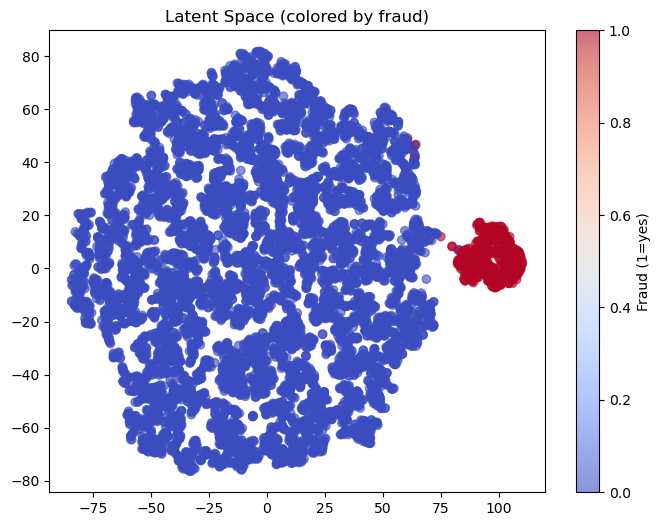

In [56]:
mock1_embeddings = extract_embeddings(encoder = mock1_autoencoder, X = X_test, y = y_test)

In [57]:
mock1_embeddings

array([[-0.8642603 , -0.03610292,  0.58817834, ..., -0.3663666 ,
         0.3165523 , -0.1176663 ],
       [ 0.9183494 ,  2.7212794 ,  1.011503  , ...,  3.1597056 ,
        -1.178356  , -0.08715898],
       [ 0.51774395,  0.76794994,  0.03233868, ...,  0.8353802 ,
         1.2821242 ,  1.2092564 ],
       ...,
       [ 1.83595   , -0.29820552, -0.33912843, ..., -0.34241354,
        -0.5394266 , -0.53932756],
       [-0.5409137 ,  0.4423583 ,  0.72679317, ..., -0.1641826 ,
         0.05988144, -0.38951504],
       [ 0.58826935,  0.82320994,  0.6379958 , ...,  0.07382986,
        -0.09258667, -0.54701304]], dtype=float32)

In [ ]:
# # Main function to run everything
# def run_autoencoder_pipeline(timeunit='l3'):
#     df = generate_mock_data()
#     X_train, X_test, y_test, scaler = prepare_data(df, timeunit=timeunit)
#     autoencoder, encoder = build_autoencoder(input_dim=X_train.shape[1])
#     train_autoencoder(autoencoder, X_train)
#     recon_error, predicted_fraud = detect_anomalies(autoencoder, X_test, y_test)
#     embeddings = extract_embeddings(encoder, X_test, y_test)
#     return {
#         "autoencoder": autoencoder,
#         "encoder": encoder,
#         "reconstruction_error": recon_error,
#         "predicted_fraud": predicted_fraud,
#         "embeddings": embeddings
#     }

In [ ]:
# Run the pipeline
results = run_autoencoder_pipeline('l3')